In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/no_summaries_cleaned_modeling_features.csv'
df = pd.read_csv(path)


In [4]:
# -----------------------------
# 2. Target Variable
# -----------------------------
target = "pretrial_recidivism"
y = df[target]
X = df.drop(columns=[target])

In [5]:
# -----------------------------
# 3. Identify feature types
# -----------------------------
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols      = X.select_dtypes(include=['int64', 'float64']).columns

In [8]:
# =========================
#  Preprocessing Pipelines
# =========================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [9]:
# =========================
#  FAST + ACCURATE Random Forest
#  Tuned for Colab (n_jobs = -1)
# =========================
rf = RandomForestClassifier(
    n_estimators=200,         # good balance of speed + accuracy
    max_depth=22,            # deeper trees = more accuracy
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced", # handles imbalance
    n_jobs=-1,               # use all CPU cores
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])


In [10]:
# =========================
#  Train-test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)


In [11]:
# =========================
#  Evaluation
# =========================
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nModel Accuracy:", acc)
print("\nClassification Report:\n", report)


Model Accuracy: 0.6345272272643082

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.65      0.73     66253
         1.0       0.34      0.59      0.43     20131

    accuracy                           0.63     86384
   macro avg       0.59      0.62      0.58     86384
weighted avg       0.72      0.63      0.66     86384



In [13]:
# Predicted probabilities (need the positive class)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)



AUC Score: 0.6588699234120026


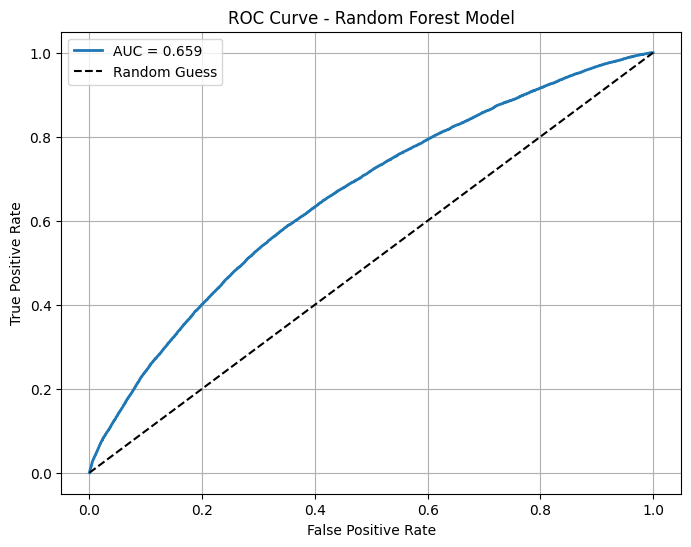

In [14]:
# =====================
#     Plot ROC Curve
# =====================
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest Model")
plt.legend()
plt.grid(True)
plt.show()